In [2]:
!conda install librosa

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - librosa

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
from glob import glob
import librosa
import warnings

warnings.filterwarnings("ignore")

In [2]:
cd ../.. 

/home/dacon/Dacon


In [5]:
# npy파일로 저장된 데이터를 불러옵니다.
africa_train_data = np.load("./dongha/voice/npy/africa_train_data.npy", allow_pickle = True)
australia_train_data = np.load("./dongha/voice/npy/australia_train_data.npy", allow_pickle = True)
canada_train_data = np.load("./dongha/voice/npy/canada_train_data.npy", allow_pickle = True)
england_train_data = np.load("./dongha/voice/npy/england_train_data.npy", allow_pickle = True)
hongkong_train_data = np.load("./dongha/voice/npy/hongkong_train_data.npy", allow_pickle = True)
us_train_data = np.load("./dongha/voice/npy/us_train_data.npy", allow_pickle = True)

#test_data = np.load("./hyup/accent/test_npy.npy", allow_pickle = True)

train_data_list = [africa_train_data, australia_train_data, canada_train_data, england_train_data, hongkong_train_data, us_train_data]

In [6]:
test_data = np.load("./hyup/accent/test.npy", allow_pickle = True)

In [7]:
# 이번 대회에서 음성은 각각 다른 길이를 갖고 있습니다.
# baseline 코드에서는 음성 중 길이가 가장 작은 길이의 데이터를 기준으로 데이터를 잘라서 사용합니다.

def get_mini(data):

    mini = 9999999
    for i in data:
        if len(i) < mini:
            mini = len(i)

    return mini

#음성들의 길이를 맞춰줍니다.

def set_length(data, d_mini):

    result = []
    for i in data:
        result.append(i[:d_mini])
    result = np.array(result)

    return result

#feature를 생성합니다.

def get_feature(data, sr = 16000, n_fft = 256, win_length = 200, hop_length = 160, n_mels = 64):
    mel = []
    for i in data:
        # win_length 는 음성을 작은 조각으로 자를때 작은 조각의 크기입니다.
        # hop_length 는 음성을 작은 조각으로 자를때 자르는 간격을 의미합니다.
        # n_mels 는 적용할 mel filter의 개수입니다.
        mel_ = librosa.feature.melspectrogram(i, sr = sr, n_fft = n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
        mel.append(mel_)
    mel = np.array(mel)
    mel = librosa.power_to_db(mel, ref = np.max)

    mel_mean = mel.mean()
    mel_std = mel.std()
    mel = (mel - mel_mean) / mel_std

    return mel

In [8]:
train_x = np.concatenate(train_data_list, axis= 0)
test_x = np.array(test_data)

# 음성의 길이 중 가장 작은 길이를 구합니다.

train_mini = get_mini(train_x)
test_mini = get_mini(test_x)

mini = np.min([train_mini, test_mini])

# data의 길이를 가장 작은 길이에 맞춰 잘라줍니다.

train_x = set_length(train_x, mini)
test_x = set_length(test_x, mini)

# librosa를 이용해 feature를 추출합니다.

train_x = get_feature(data = train_x)
test_x = get_feature(data = test_x)

train_x = train_x.reshape(-1, train_x.shape[1], train_x.shape[2], 1)
test_x = test_x.reshape(-1, test_x.shape[1], test_x.shape[2], 1)

In [9]:
# train_data의 label을 생성해 줍니다.

train_y = np.concatenate((np.zeros(len(africa_train_data), dtype = np.int),
                        np.ones(len(australia_train_data), dtype = np.int),
                         np.ones(len(canada_train_data), dtype = np.int) * 2,
                         np.ones(len(england_train_data), dtype = np.int) * 3,
                         np.ones(len(hongkong_train_data), dtype = np.int) * 4,
                         np.ones(len(us_train_data), dtype = np.int) * 5), axis = 0)

In [10]:
train_x.shape, train_y.shape, test_x.shape

((63858, 64, 501, 1), (63858,), (6100, 64, 501, 1))

In [21]:
train_y = pd.get_dummies(train_y).to_numpy(dtype = 'long')

In [11]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms

In [12]:
torch.cuda.empty_cache()

In [13]:
class ToTensor(object):
    """numpy array를 tensor(torch)로 변환합니다."""
    def __call__(self, sample):
        x, y = sample['x'], sample['y']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        x = x.transpose((2, 0, 1))
        return {'x': torch.FloatTensor(x),
                'y': torch.FloatTensor(y)}
to_tensor = transforms.Compose([
                      ToTensor() 
])
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self,train_x,train_y,transforms=to_tensor):
        self.x_data = train_x
        self.y_data = train_y
        self.transforms = transforms# Transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx): 
        
        x = self.x_data[idx]
        y = self.y_data[idx]
        sample = {'x': x, 'y': y}
        if self.transforms:
            sample = self.transforms(sample)
        y = y.astype(np.float32)
        
        
        return (x,y)

In [22]:
dataset = CustomDataset(train_x,train_y)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [49]:
import matplotlib.pyplot as plt

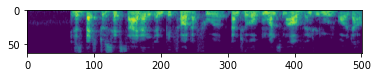

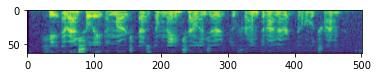

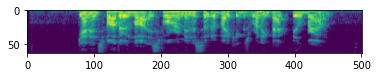

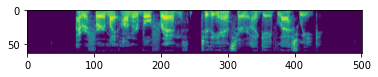

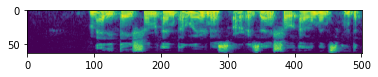

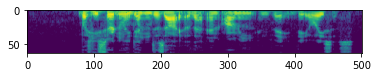

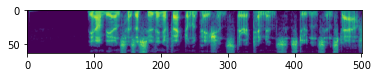

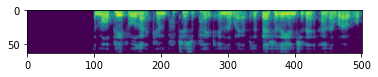

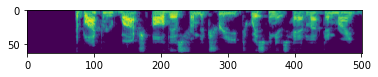

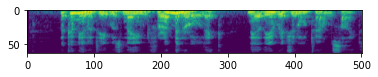

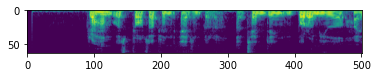

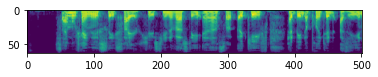

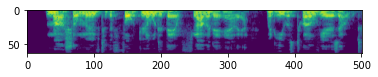

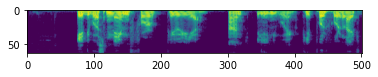

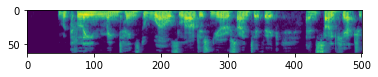

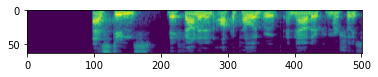

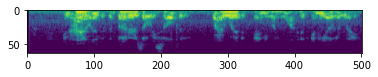

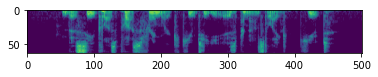

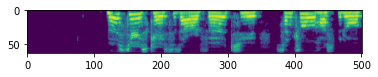

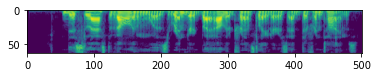

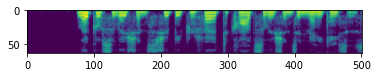

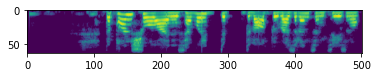

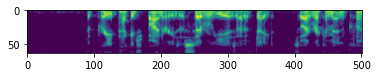

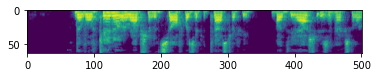

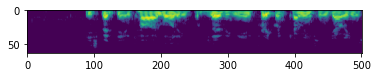

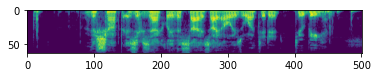

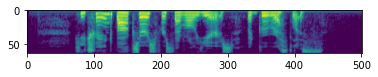

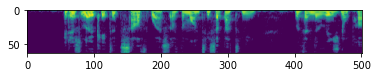

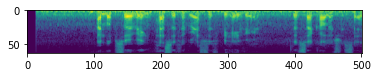

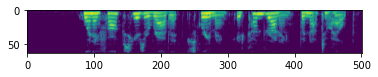

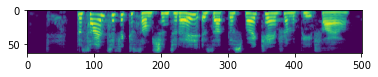

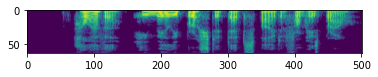

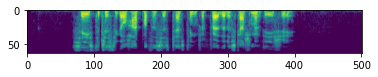

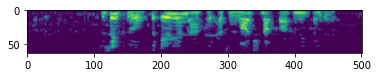

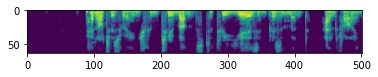

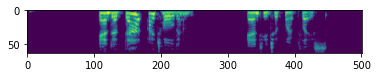

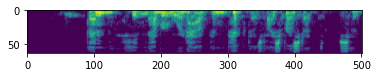

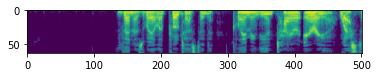

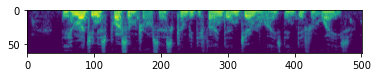

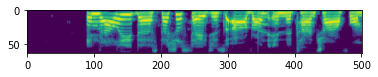

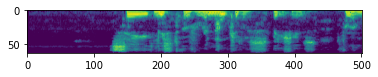

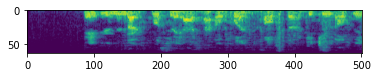

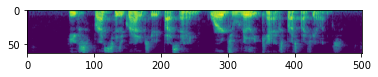

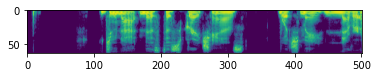

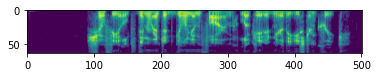

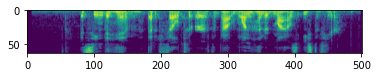

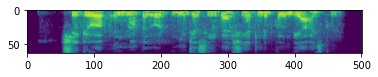

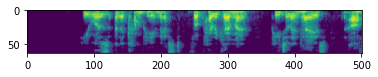

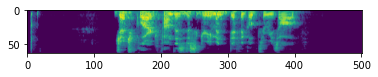

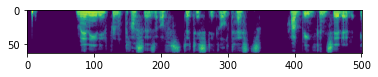

In [122]:
for i in range(50):
    plt.imshow(sample[i][:,:,0])
    plt.show()

# 모델링

In [14]:
device = torch.device("cuda:3")

In [15]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_prune

In [29]:
class MultiLabelResnet(nn.Module):
    def __init__(self):
        super(MultiLabelResnet, self).__init__()
        self.conv2d = nn.Conv2d(64, 3, 1, stride=1)
        self.resnet = timm.create_model('resnet101', pretrained=False) 
        self.FC = nn.Linear(1000, 6)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        x = F.silu(self.conv2d(x))

        # resnet18을 추가
        x = F.silu(self.resnet(x))

        # 마지막 출력에 nn.Linear를 추가
        # multilabel을 예측해야 하기 때문에
        # softmax가 아닌 sigmoid를 적용
        #x = self.FC(x)
        x = torch.sigmoid(self.FC(x))
        return x
# 모델 선언

model = MultiLabelResnet()
model.to(device)

MultiLabelResnet(
  (conv2d): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=

In [30]:
dataset = CustomDataset(train_x,train_y)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion  = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [32]:
from tqdm import tqdm

# 모델의 dropoupt, batchnormalization를 train 모드로 설정
model.train()

for epoch in range(30):
    # 1개 epoch 훈련
    train_acc_list = []
    with tqdm(dataloader,#train_data_loader를 iterative하게 반환
            total=dataloader.__len__(), # train_data_loader의 크기
            unit="batch") as train_bar: # 한번 반환하는 smaple의 단위는 "batch"
        for idx,sample in enumerate(train_bar):
            if idx == 249 :
                break
            train_bar.set_description(f"Train Epoch {epoch}")
            # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
            # 참고)https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
            optimizer.zero_grad()

            images, labels = sample
            # tensor를 gpu에 올리기 
            images = images.to(device)
            labels = labels.to(device)


            
            # .forward()에서 중간 노드의 gradient를 계산
            with torch.set_grad_enabled(True):
                # 모델 예측
                probs = model(images)
                probs = F.softmax(probs)
               # probs = (probs == probs.max()) * 1.0
                #loss = criterion(probs, y_train)
                
                
                loss = criterion(probs, labels)
                #loss = criterion(probs, torch.max(y_train, 1)[1])

                loss.backward()
                optimizer.step()
                
                probs  = probs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()
                # train accuracy 계산
                cnt = 0
                for i in range(256):
                    
                    if probs[i].argmax() == labels[i].argmax():
                        cnt +=1
                
                #preds = probs > 0.5
                #batch_acc = (labels == preds).mean()
                batch_acc = cnt/256
                train_acc_list.append(batch_acc)
                train_acc = np.mean(train_acc_list)

            # 현재 progress bar에 현재 미니배치의 loss 결과 출력
            train_bar.set_postfix(train_loss= loss.item(),
                                    train_acc = train_acc)
    scheduler.step()
            

Train Epoch 27:  48%|████▊     | 121/250 [01:26<01:31,  1.40batch/s, train_acc=0.601, train_loss=0.353]


KeyboardInterrupt: 

In [290]:
ls

HDD_01/  HDD_04/     cheating/   dongha/  hyup/      kookbal/
HDD_02/  analytics/  cpt_data/   eunil/   jenkins/   results/
HDD_03/  bdg/        dacon-api/  front/   junyoung/  script/


In [33]:
torch.save(model.state_dict(),'./hyup/hyup.pth')

accent/  baseline1.pth  baseline_modify.pth  log_analysis/  visual/


In [18]:
model = MultiLabelResnet()
model.load_state_dict(torch.load('baseline_modify.pth'))

<All keys matched successfully>

In [34]:
test_ = pd.read_csv('./hyup/accent/test_.csv',)
test_ = test_.iloc[:,1:]

In [36]:
test_y = pd.DataFrame(index=range(0,len(test_x)), columns=['0', '1', '2', '3', '4', '5'])
test_y = test_y.fillna(0).to_numpy()
dataset = CustomDataset(test_x,test_y)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

 

In [ ]:
pred_ = []

In [37]:
model.eval()
pred_ = []
for idx, sample in enumerate(dataloader):
    with torch.no_grad():
        # 추론
        model.eval()
        images,_ = sample
        images = images.to(device)
        probs  = model(images)
        probs = F.softmax(probs)
        probs = probs.cpu().detach().numpy()
        pred_.append(probs[0])
        

In [38]:
pred = pred_
pred[0]

array([0.10591365, 0.10591365, 0.10646205, 0.28789392, 0.10591365,
       0.28790313], dtype=float32)

In [40]:
sample_submission = pd.read_csv('hyup/accent/sample_submission.csv')

In [41]:
def cov_type(data):
    return np.int(data)

# 처음에 살펴본 것처럼 glob로 test data의 path는 sample_submission의 id와 같이 1,2,3,4,5.....으로 정렬 되어있지 않습니다.
# 만들어둔 test_ 데이터프레임을 이용하여 sample_submission과 predict값의 id를 맞춰줍니다.

result = pd.concat([test_, pd.DataFrame(pred)], axis = 1).iloc[:, 1:]

result["id"] = result["id"].apply(lambda x : cov_type(x))

result = pd.merge(sample_submission["id"], result)
result.columns = sample_submission.columns

In [42]:
result.to_csv('result.csv',index= False)